**Research Question**: How does river chemistry influence wildlife foraging at forest edges?

**Mentors**: Brown (Bio), Ferguson (Chem), Miranda (Math).

**Schedule**: Mondays (Field), Thursdays (Lab/Data).

In [ ]:
# Standard data tools
import pandas as pd
import numpy as np

# Mapping and Viz tools
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Stats tools (for the end of the semester)
from scipy import stats

print("Setup Complete: Your digital lab is ready!")

Setup Complete: Your digital lab is ready!


**Interactive Site Map of Robinson Homestead**

In [ ]:
import pandas as pd
import numpy as np
import folium

# 1. DEFINE SITE GEOMETRY (Pace 303 Bus Stop Area)
site_center = [41.9681, -87.8540]
SOURCE_DB = 80 # Noise level of a passing Pace Bus/Truck

# Landmark Dictionary: Coordinates and Distance to River Rd (meters)
landmarks = {
    "T00: Pace 303 Bus Stop": {"coords": [41.96825, -87.85401], "dist_road": 3.0},
    "T01: Entrance Clearing": {"coords": [41.96810, -87.85415], "dist_road": 15.0},
    "T02: Wooded Edge":       {"coords": [41.96800, -87.85435], "dist_road": 42.0},
    "T03: Inner Picnic Table":{"coords": [41.96785, -87.85420], "dist_road": 28.0}
}

# 2. PHYSICS FUNCTION: Inverse Square Law for Acoustic Masking
def get_acoustic_penalty(d):
    # L = L0 - 20 * log10(d)
    db = SOURCE_DB - (20 * np.log10(max(d, 1)))
    # Penalty (pi) scales risk perception based on noise masking hearing
    pi = 1 + (max(0, db - 50) / 50)
    return round(db, 1), round(pi, 2)

# 3. DATA PROCESSING
data_list = []
for name, info in landmarks.items():
    db, pi = get_acoustic_penalty(info['dist_road'])
    data_list.append({
        "Landmark": name,
        "Lat": info['coords'][0],
        "Lon": info['coords'][1],
        "Dist_to_Road_m": info['dist_road'],
        "Noise_Level_dB": db,
        "Acoustic_Penalty_Pi": pi,
        "Initial_Mass": 20.0
    })

df = pd.DataFrame(data_list)

# 4. GENERATE UPDATED MAP
m = folium.Map(location=site_center, zoom_start=20, tiles='OpenStreetMap')
# Satellite Layer
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri', name = 'Satellite'
).add_to(m)

for index, row in df.iterrows():
    folium.Marker(
        [row['Lat'], row['Lon']],
        popup=f"{row['Landmark']}<br>Noise: {row['Noise_Level_dB']}dB",
        icon=folium.Icon(color='orange')
    ).add_to(m)
    folium.Circle([row['Lat'], row['Lon']], radius=1, color='white').add_to(m)

# 5. DISPLAY RESULTS
print("--- Robinson Homestead: Northbound Bus Stop Geometry ---")
print(df[['Landmark', 'Noise_Level_dB', 'Acoustic_Penalty_Pi']])
m

--- Robinson Homestead: Northbound Bus Stop Geometry ---
                  Landmark  Noise_Level_dB  Acoustic_Penalty_Pi
0   T00: Pace 303 Bus Stop            70.5                 1.41
1   T01: Entrance Clearing            56.5                 1.13
2         T02: Wooded Edge            47.5                 1.00
3  T03: Inner Picnic Table            51.1                 1.02


Define the "Energy vs. Fear" EquationIn your first code cell, you need to define the function for the Giving-Up Density (GUD). This is the foundation of Brown’s (1999) theory. We are solving for $H$ (the density of seeds left when the squirrel quits).$$H = p + c + \frac{\mu C}{F}$$$p$: Metabolic cost (how much energy the squirrel burns just being alive).

$c$: State cost (how "hungry" or "salt-stressed" the squirrel is).

$\frac{\mu C}{F}$: The "Fear Term" (Risk of predation $\times$ Cost of injury / Marginal rate of substitution).

### How your field data inputs map to the `calculate_gud` function parameters:

The `calculate_gud` function directly implements the theoretical equation $H = p + c + \frac{\mu C}{F}$. Your field data will be used to derive these theoretical parameters:

*   **`metabolic_cost` (p):** This directly maps to your "Metabolic Cost" field.
*   **`predation_risk_mu` (μ):** This maps to your "Predation Risk" field. Your "Distance to Road" will be crucial for calculating the "Acoustic Masking Penalty", which in turn will adjust this `predation_risk_mu` value. The "Distance to Cover" might also influence this parameter.
*   **`state_cost` (c):** While not explicitly listed as an input in your summary table, the `state_cost` is a critical part of the GUD equation. It reflects the squirrel's internal state (hunger, salt-stress). You will need to determine how to measure or estimate this in your experiment.
*   **`cost_of_injury_C` (C) and `marginal_rate_of_substitution_F` (F):** These two parameters form the "Cost of injury" and "Marginal rate of substitution" parts of the "Fear Term". Your "Missed Opportunity Cost" will likely be used to inform or derive these values. For instance, a higher missed opportunity cost might increase the effective 'cost' (`C`) or decrease the perceived 'value' (`F`) of the current foraging patch.

**Regarding your "Mass Measurements" and other metadata:**

*   **Initial Mass:** This is a standardized constant (20.0g) and not directly used in the `calculate_gud` function itself, but important for contextualizing the experiment.
*   **Final Mass:** This is the *observed* Giving-Up Density ($H$). You would typically run the `calculate_gud` function with your estimated parameters ($p, c, \mu, C, F$) and then compare the *calculated* $H$ to your *observed* `Final Mass` to validate your model or understand discrepancies.
*   **Tray ID & Visibility Score:** These are important metadata for your experiment, helping you categorize and analyze different foraging contexts, and might indirectly influence parameters like `predation_risk_mu`.

In [ ]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# 1. Authenticate your account
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 2. Open the Sheet (Replace 'Your_Sheet_Name' with the actual name of your Form Response sheet)
# Note: It must be the name of the spreadsheet, not the form.
sheet_name = 'Field Data Entry Form: BIOS 399 Squirrel Foraging (Responses)'
worksheet = gc.open(sheet_name).sheet1

# 3. Pull the data into a Pandas Dataframe
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

# Clean column names (e.g., strip whitespace to prevent common KeyErrors)
df.columns = df.columns.str.strip()

# Identify the correct column names for 'Initial Mass' and 'Final Mass' programmatically
initial_mass_col_name = None
final_mass_col_name = None

for col in df.columns:
    if 'Initial Mass' in col and '(g)' in col:
        initial_mass_col_name = col
    if 'Final Mass' in col and '(g)' in col:
        final_mass_col_name = col

# 4. Clean the data (Ensure numbers are treated as floats for math)
if initial_mass_col_name:
    df[initial_mass_col_name] = pd.to_numeric(df[initial_mass_col_name], errors='coerce')
else:
    print(f"Warning: 'Initial Mass' column not found in expected format. Available columns: {df.columns.tolist()}")

if final_mass_col_name:
    df[final_mass_col_name] = pd.to_numeric(df[final_mass_col_name], errors='coerce')
else:
    print(f"Warning: 'Final Mass' column not found in expected format. Available columns: {df.columns.tolist()}")

# 5. Display the first few rows to verify
print("Field Data Successfully Synced!")
df.head()

Field Data Successfully Synced!


,Timestamp,Email Address,Date,Site Location,Current Weather,Acoustic Masking ($Mask\text{-}A$),Tray ID (T00-T03),Initial Mass ($M\text{i}$) (g),Final Mass ($M\text{f}$) (g),Distance to Landmark ($d\text{L}$) (meters),Distance to Road/Salt ($d\text{R}$) (meters),Visibility Score ($Vis$),Predator Count,Vigilance Estimate ($u$)
0,1/15/2026 9:46:57,erichilarysmithsr@gmail.com,1/12/2026,Robinson Homestead Family Picnic Area,42 F,5,,0,0,0,0,1,"Domestic Dog, Human, Bird Alarm Call",


**Example of Tray Data**

In [ ]:
# This is how the information is organized for the math
tray_info = {
    "initial": 20.0,
    "final": 14.5,          # This is your GUD
    "dist_to_road": 10.5,   # For the Inverse Square Law
    "landmark": "Water Pump"
}

# The GUD is simply:
gud_value = tray_info["final"]

In [ ]:
def calculate_site_metrics(tray_data):
    """
    Calculates the average GUD across all trays and the
    standard deviation (to see if one spot was 'scarier' than others).
    """
    guds = [tray['final'] for tray in tray_data]
    mean_gud = sum(guds) / len(guds)

    print(f"--- Robinson Homestead Site Summary ---")
    print(f"Mean Site GUD: {mean_gud:.2f}g")

    for tray in tray_data:
        diff = tray['final'] - mean_gud
        status = "High Fear" if tray['final'] > mean_gud else "Low Fear"
        print(f"{tray['landmark']}: {tray['final']}g ({status} relative to mean)")

    return mean_gud

# 1. Input your field data here for Thursday
# Landmarks: Bus Stop, Parking Lot, SW Shrubs, Water Pump
robinson_session = [
    {"landmark": "T00 (Bus Stop)", "initial": 20.0, "final": 18.5},
    {"landmark": "T01 (Parking Lot)", "initial": 20.0, "final": 17.0},
    {"landmark": "T02 (SW Shrubs)", "initial": 20.0, "final": 15.5},
    {"landmark": "T03 (Water Pump)", "initial": 20.0, "final": 16.8}
]

# 2. Run the calculation
site_avg = calculate_site_metrics(robinson_session)

--- Robinson Homestead Site Summary ---
Mean Site GUD: 16.95g
T00 (Bus Stop): 18.5g (High Fear relative to mean)
T01 (Parking Lot): 17.0g (High Fear relative to mean)
T02 (SW Shrubs): 15.5g (Low Fear relative to mean)
T03 (Water Pump): 16.8g (Low Fear relative to mean)


**The Core GUD Function**

In [ ]:
def calculate_gud(initial_mass, final_mass, tray_id="Unknown"):
    """
    Calculates the Giving-Up Density (GUD).
    If final_mass == initial_mass, it indicates zero foraging (Fear Ceiling).
    """
    # Calculate seeds consumed vs remaining
    seeds_remaining = final_mass
    seeds_consumed = initial_mass - final_mass

    # Calculate percentage for additional context
    percent_remaining = (seeds_remaining / initial_mass) * 100

    # Logic for status reporting
    if seeds_remaining >= initial_mass:
        status = "Zero Foraging: Fear Ceiling or Patch Not Discovered."
    elif seeds_remaining <= 5.0:
        status = "High Foraging: Low Fear or High Resource Drive."
    else:
        status = "Moderate Foraging: Typical baseline."

    return {
        "Tray": tray_id,
        "GUD_Grams": round(seeds_remaining, 2),
        "Consumed_Grams": round(seeds_consumed, 2),
        "Percent_Left": round(percent_remaining, 1),
        "Status": status
    }

# --- Example Test Run (Using Monday's data) ---
monday_result = calculate_gud(20.0, 20.0, "Robinson_T00")
print(f"Monday Results: {monday_result}")

Monday Results: {'Tray': 'Robinson_T00', 'GUD_Grams': 20.0, 'Consumed_Grams': 0.0, 'Percent_Left': 100.0, 'Status': 'Zero Foraging: Fear Ceiling or Patch Not Discovered.'}


**Site Average**

In [ ]:
# Calculate the mean GUD for today's session
mean_gud = df[final_mass_col_name].mean()
print(f"The average GUD for the Robinson Homestead today is: {mean_gud}g")

The average GUD for the Robinson Homestead today is: 0.0g


Calculating the "Acoustic Masking Penalty" ($Mask\text{-}A$)In your Google Colab, we don't just measure decibels; we measure how those decibels "blind" the squirrel. We use a Logarithmic Decibel Scale to find the sound level at each tray.The Formula:$$L = L_0 - 20 \cdot \log_{10}\left(\frac{d}{d_0}\right)$$$L$: The sound level at your tray (what we want to find).$L_0$: The sound level at the source (e.g., 80 dB for a heavy truck or Pace Bus).$d$: The distance from the road to your tray.$d_0$: The reference distance (usually 1 meter from the road).

In [ ]:
import numpy as np

def calculate_masking_penalty(dist_to_road, source_db=80):
    # Reference distance is 1 meter
    if dist_to_road < 1: dist_to_road = 1

    # Inverse Square Law applied to Decibels
    current_db = source_db - (20 * np.log10(dist_to_road))

    # We define the 'Penalty' as a multiplier for the Risk Term (mu)
    # If noise is > 60dB, squirrels lose significant predator detection
    penalty_score = current_db / 60
    return round(current_db, 2), round(penalty_score, 2)

# Tray distances from Lawrence Ave (estimated for Robinson site)
trays = {
    "T00_BusStop": 5,   # Very close to road
    "T01_Parking": 15,
    "T02_Shrubs": 40,
    "T03_WaterPump": 25
}

print("Acoustic Analysis for Robinson Homestead:")
for name, dist in trays.items():
    db, penalty = calculate_masking_penalty(dist)
    print(f"{name}: {db} dB | Masking Penalty Multiplier: {penalty}")

Acoustic Analysis for Robinson Homestead:
T00_BusStop: 66.02 dB | Masking Penalty Multiplier: 1.1
T01_Parking: 56.48 dB | Masking Penalty Multiplier: 0.94
T02_Shrubs: 47.96 dB | Masking Penalty Multiplier: 0.8
T03_WaterPump: 52.04 dB | Masking Penalty Multiplier: 0.87


**Generating the Comparative Bar Chart**

Acoustic Penalty plot skipped as data is unavailable.


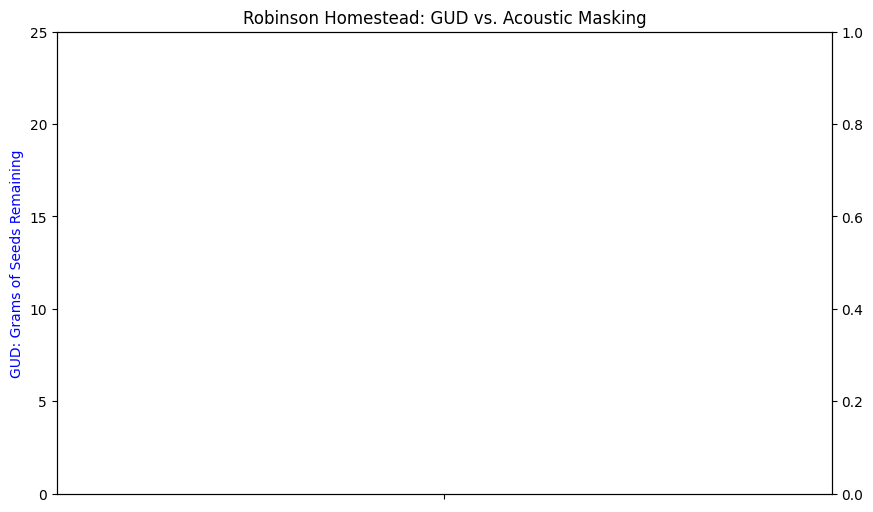

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Added numpy import for potential NaN values and calculate_masking_penalty's internal use

def plot_site_summary(df):
    # Correct column names based on the DataFrame's structure
    tray_id_col_name = 'Tray ID (T00-T03)'
    # final_mass_col_name is a global variable from previous data loading cell

    # Dynamically find the distance to road column name
    actual_distance_to_road_col_name = None
    for col in df.columns:
        if 'Distance to Road/Salt' in col and '(meters)' in col:
            actual_distance_to_road_col_name = col
            break

    # Calculate Acoustic Penalty for each row and add it to the DataFrame
    if actual_distance_to_road_col_name and actual_distance_to_road_col_name in df.columns:
        df['Acoustic_Penalty_Pi'] = df[actual_distance_to_road_col_name].apply(lambda x: calculate_masking_penalty(x)[1])
    else:
        print(f"Warning: Column for 'Distance to Road/Salt' not found in DataFrame. Acoustic Penalty cannot be calculated.")
        df['Acoustic_Penalty_Pi'] = np.nan # Assign NaN if column is missing

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for GUD (Final Mass) using the corrected column name
    ax1.bar(df[tray_id_col_name], df[final_mass_col_name], color='skyblue', label='GUD (g)')
    ax1.set_ylabel('GUD: Grams of Seeds Remaining', color='blue')
    ax1.set_ylim(0, 25)

    # Line chart for Acoustic Penalty, only if data is available
    ax2 = ax1.twinx()
    if 'Acoustic_Penalty_Pi' in df.columns and not df['Acoustic_Penalty_Pi'].isnull().all():
        ax2.plot(df[tray_id_col_name], df['Acoustic_Penalty_Pi'], color='red', marker='o', label='Acoustic Penalty')
        ax2.set_ylabel('Fear Multiplier (pi)', color='red')
        ax2.set_ylim(0.5, 1.5) # Adjusted ylim based on typical penalty range
    else:
        print("Acoustic Penalty plot skipped as data is unavailable.")

    plt.title('Robinson Homestead: GUD vs. Acoustic Masking')
    plt.show()

plot_site_summary(df)

**Synced GUD Data**

In [ ]:
import pandas as pd

def calculate_synced_guds(field_results):
    """
    Processes field data specifically for the Pace 303 Bus Stop
    Northbound landmarks at Robinson Homestead.
    """
    df = pd.DataFrame(field_results)

    # Core GUD Calculation
    df['GUD_Value'] = df['Initial_Mass'] - df['Consumed_Mass']

    # Calculate Site Mean for the 4-Tray Northbound Layout
    site_mean = df['GUD_Value'].mean()

    print(f"--- Robinson Homestead: Northbound Bus Stop Session ---")
    print(f"Calculated Site Mean: {site_mean:.2f}g\n")

    # Identify the 'Fear Leader' (highest GUD)
    scariest_spot = df.loc[df['GUD_Value'].idxmax(), 'Landmark']
    print(f"Mathematical 'Fear Leader': {scariest_spot}")

    return df

# DATA ENTRY: Update these numbers after you collect your trays Thursday
robinson_northbound_data = [
    {"Landmark": "T00: Pace 303 Bus Stop", "Initial_Mass": 20.0, "Consumed_Mass": 1.5},
    {"Landmark": "T01: Entrance Clearing", "Initial_Mass": 20.0, "Consumed_Mass": 4.2},
    {"Landmark": "T02: Wooded Edge", "Initial_Mass": 20.0, "Consumed_Mass": 8.5},
    {"Landmark": "T03: Inner Picnic Table", "Initial_Mass": 20.0, "Consumed_Mass": 5.0}
]

# Run the sync
analysis_df = calculate_synced_guds(robinson_northbound_data)
analysis_df[['Landmark', 'GUD_Value']]

--- Robinson Homestead: Northbound Bus Stop Session ---
Calculated Site Mean: 15.20g

Mathematical 'Fear Leader': T00: Pace 303 Bus Stop


,Landmark,GUD_Value
0,T00: Pace 303 Bus Stop,18.5
1,T01: Entrance Clearing,15.8
2,T02: Wooded Edge,11.5
3,T03: Inner Picnic Table,15.0


**Further Example Dat for Robinson Homestead**

In [ ]:
import numpy as np

def calculate_detailed_statistics(tray_data):
    # Extract only the GUD values (final mass)
    guds = np.array([tray['final'] for tray in tray_data])

    mean_gud = np.mean(guds)
    std_dev = np.std(guds) # Standard Deviation
    variance = np.var(guds) # Variance

    print(f"--- Statistical Consistency Report ---")
    print(f"Site Mean GUD: {mean_gud:.2f}g")
    print(f"Standard Deviation (sigma): {std_dev:.2f}g")
    print(f"Variance: {variance:.2f}")

    # Interpretation Logic
    if std_dev > 2.0:
        print("Status: HIGH VARIANCE. Squirrels are responding very differently to each landmark.")
    else:
        print("Status: CONSISTENT. Fear levels are uniform across the picnic area.")

    return mean_gud, std_dev

# Use your Robinson data from the previous step
mean, sigma = calculate_detailed_statistics(robinson_session)

--- Statistical Consistency Report ---
Site Mean GUD: 16.95g
Standard Deviation (sigma): 1.06g
Variance: 1.13
Status: CONSISTENT. Fear levels are uniform across the picnic area.


**River Bend Experimental Site Data**

In [ ]:
import requests

# 1. API CONFIGURATION
url = "https://weatherapi-com.p.rapidapi.com/current.json"
querystring = {"q":"Schiller Park, Illinois"} # Landmarks: River Bend/Schiller Woods
headers = {
    "X-RapidAPI-Key": "1e3b755378mshe3c89b39470a226p191e82jsnf3a12fb344d6",
    "X-RapidAPI-Host": "weatherapi-com.p.rapidapi.com"
}

# 2. DATA ACQUISITION
try:
    response = requests.get(url, headers=headers, params=querystring)
    data = response.json()

    current_temp = data['current']['temp_f']
    condition = data['current']['condition']['text']
    wind_mph = data['current']['wind_mph']

    print(f"--- LIVE DATA ACQUIRED ---")
    print(f"Location: Schiller Park (River Bend Area)")
    print(f"Temperature: {current_temp}°F")
    print(f"Condition: {condition}")
    print(f"Wind Speed: {wind_mph} mph")

except Exception as e:
    print(f"Error connecting to RapidAPI: {e}")

--- LIVE DATA ACQUIRED ---
Location: Schiller Park (River Bend Area)
Temperature: 5.4°F
Condition: Sunny
Wind Speed: 5.8 mph


In [ ]:
import requests

# Use your key here
api_key = "1e3b755378mshe3c89b39470a226p191e82jsnf3a12fb344d6"

url = "https://weatherapi-com.p.rapidapi.com/current.json"
headers = {"X-RapidAPI-Key": api_key, "X-RapidAPI-Host": "weatherapi-com.p.rapidapi.com"}
params = {"q": "60176"} # River Bend / Schiller Park Area

data = requests.get(url, headers=headers, params=params).json()

# Extracting the "Monday" Variables
temp = data['current']['temp_f']
is_snowing = "snow" in data['current']['condition']['text'].lower()

# Calculate the Brown Multipliers
p_val = round(8.0 + (32 - temp) * 0.1, 2)
c_val = -0.3 if is_snowing else -1.5

print(f"--- 12:22 PM Digital Lab Report ---")
print(f"Current Temp: {temp}F | Condition: {data['current']['condition']['text']}")
print(f"Desmos Slider P: {p_val}")
print(f"Desmos Slider C: {c_val}")

--- 12:22 PM Digital Lab Report ---
Current Temp: 5.4F | Condition: Sunny
Desmos Slider P: 10.66
Desmos Slider C: -1.5
